In [1]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.signal import iirfilter, lfilter

In [2]:
class HarmonicNoisePlotter:
    def __init__(self, root):
        # Initialization of the main window
        self.root = root
        self.root.title("Harmonic Noise Plotter")

        # Initialize variables for GUI elements
        self.amplitude = tk.DoubleVar(value=1.0)
        self.frequency = tk.DoubleVar(value=1.0)
        self.phase = tk.DoubleVar(value=0.0)
        self.noise_amplitude = tk.DoubleVar(value=0.2)
        self.noise_covariance = tk.DoubleVar(value=0.1)
        self.show_noise = tk.BooleanVar(value=True)
        self.filter_cutoff = tk.DoubleVar(value=0.2)
        self.filter_order = tk.IntVar(value=4)
        self.use_filter = tk.BooleanVar(value=False)
        self.filter_entry = tk.StringVar(value="")  # Variable to store custom filter coefficients

        # Create GUI elements
        self.create_widgets()
        self.plot()

    def create_widgets(self):
        # Create sliders and checkboxes for various parameters
        self.create_slider("Амплітуда", self.amplitude, 0.1, 2.0, row=0)
        self.create_slider("Частота", self.frequency, 0.1, 5.0, row=1)
        self.create_slider("Фаза", self.phase, -np.pi, np.pi, row=2)
        self.create_slider("Амплітуда шуму", self.noise_amplitude, 0.0, 1.0, row=3)
        self.create_slider("Дисперсія шуму", self.noise_covariance, 0.0, 1.0, row=4)
        self.create_checkbox("Показати шум", self.show_noise, row=5)
        self.create_checkbox("Показати фільтр", self.use_filter, row=6)

        # Графік
        self.figure, self.ax = plt.subplots(figsize=(8, 6))
        self.canvas = FigureCanvasTkAgg(self.figure, master=self.root)
        self.canvas_widget = self.canvas.get_tk_widget()
        self.canvas_widget.grid(row=0, column=2, rowspan=6)

        # Створення мітки для введення частоти фільтра
        ttk.Label(self.root, text="Частота фільтра").grid(row=7, column=0)
        # Створення шкали для вибору частоти фільтра
        ttk.Scale(self.root, from_=0.1, to=10.0, variable=self.filter_cutoff, orient=tk.HORIZONTAL,
                  length=200, command=lambda event=None: self.plot()).grid(row=7, column=1)

        ttk.Label(self.root, text="Порядок фільтра").grid(row=8, column=0)
        ttk.Scale(self.root, from_=1, to=10, variable=self.filter_order, orient=tk.HORIZONTAL,
                  length=200, command=lambda event=None: self.plot()).grid(row=8, column=1)

        # Create buttons for actions
        ttk.Button(self.root, text="Закрити графік", command=self.close_plot).grid(row=8, column=2)
        ttk.Button(self.root, text="Reset", command=self.reset).grid(row=8, column=1, columnspan=2)

        # Set window size
        self.root.geometry("1400x800")

    def create_slider(self, label, var, from_, to, row, column=1):
        ttk.Label(self.root, text=label).grid(row=row, column=0)
        ttk.Scale(self.root, from_=from_, to=to, variable=var, orient=tk.HORIZONTAL, length=200, command=lambda event=None: self.plot()).grid(row=row, column=column)

    def create_checkbox(self, label, var, row, column=1, columnspan=1):
        ttk.Label(self.root, text=label).grid(row=row, column=0)
        ttk.Checkbutton(self.root, variable=var, command=self.plot, onvalue=True, offvalue=False).grid(row=row, column=column, columnspan=columnspan)

    def create_entry(self, label, var, row, column=1):
        ttk.Label(self.root, text=label).grid(row=row, column=0)
        ttk.Entry(self.root, textvariable=var).grid(row=row, column=column)

    def plot(self):
        t = np.linspace(0, 10, 1000)
        signal_without_noise = self.amplitude.get() * np.sin(2 * np.pi * self.frequency.get() * t + self.phase.get())

        # Додавання шуму до сигналу в залежності від параметрів
        if self.show_noise.get():
            # Генерація випадкового шуму з нормальним розподілом
            noise = np.random.normal(0, np.sqrt(self.noise_covariance.get()), len(t))
            # Додавання шуму до сигналу без шуму
            signal_with_noise = signal_without_noise + self.noise_amplitude.get() * noise
        else:
            # Якщо опція не включена, сигнал з шумом буде ідентичним сигналу без шуму
            signal_with_noise = signal_without_noise

        # Використання фільтрації, якщо опція включена
        if self.use_filter.get():
            # Отримання параметрів фільтрації
            filter_order = self.filter_order.get()
            filter_cutoff = min(self.filter_cutoff.get(), 0.5 * self.frequency.get())
            # Встановлення частоти дискретизації для фільтрації
            fs = 10 * self.frequency.get()  # Використовуємо множник для забезпечення широкого діапазону частот
            # Застосування IIR-фільтра
            b, a = iirfilter(filter_order, filter_cutoff, fs=fs, btype='low', analog=False, ftype='butter')
            filtered_signal = lfilter(b, a, signal_with_noise)

            self.ax.clear()
            self.ax.plot(t, signal_with_noise, label="Signal with Noise")
            self.ax.plot(t, signal_without_noise, label="Original Signal", linestyle='-')
            self.ax.plot(t, filtered_signal, label="Filtered Signal", linestyle=':')
            self.ax.legend()
            self.ax.set_title("Harmonic")
            self.canvas.draw()
        else:
            self.ax.clear()
            self.ax.plot(t, signal_with_noise, label="Signal with Noise")
            self.ax.plot(t, signal_without_noise, label="Original Signal", linestyle='-')
            self.ax.legend()
            self.ax.set_title("Harmonic")
            self.canvas.draw()

    def reset(self):
        self.amplitude.set(1.0)
        self.frequency.set(1.0)
        self.phase.set(0.0)
        self.noise_amplitude.set(0.2)
        self.noise_covariance.set(0.1)
        self.show_noise.set(True)
        self.use_filter.set(False)
        self.filter_entry.set("")  # Reset the custom filter coefficients
        self.plot()

    def close_plot(self):
        self.root.quit()
        plt.close()

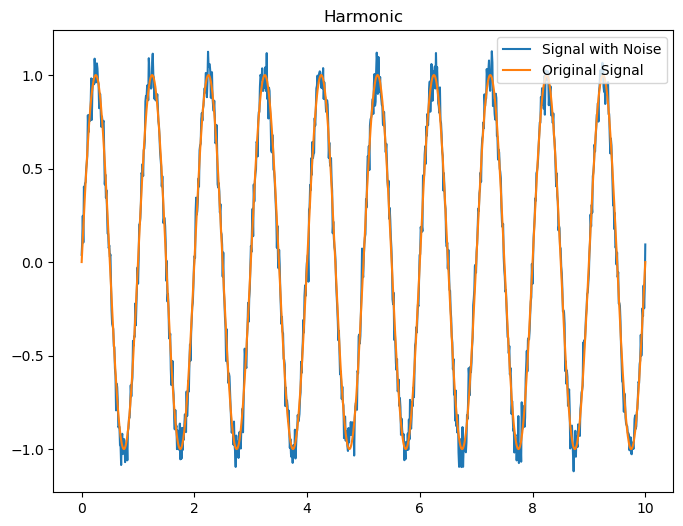

In [3]:
if __name__ == "__main__":
    # Create the main window and run the code
    root = tk.Tk()
    app = HarmonicNoisePlotter(root)
    root.mainloop()